# Bayesian Inference for Time-Varying R(t) with the SAFIR Model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OJWatson/emidm/blob/main/docs/notebooks/safir_inference.ipynb)

This notebook demonstrates how to:

1. Set up a realistic age-structured SAFIR model with UK demographics
2. Simulate a COVID-19-like epidemic with time-varying R(t) matching the UK 2020 pattern
3. Use Bayesian inference to estimate the time-varying R(t) from death data

The key feature is that **emidm**'s differentiable SAFIR model enables gradient-based inference, making it much faster than derivative-free methods.

---

**Authors:** Oliver (OJ) Watson. 2025. MIT Licence 2.0.
**Affiliation:** MRC-GIDA, School of Public Health, Imperial College London

## 1. Setup and Installation

In [15]:
# Install emidm with JAX and Bayesian inference support (uncomment if needed)
# !pip install "emidm[jax,bayes] @ git+https://github.com/OJWatson/emidm.git"

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# JAX imports
import jax
import jax.numpy as jnp

# emidm imports
from emidm import run_diff_safir_simulation, make_diff_safir_model
from emidm.optim import optimize_params

# Set random seed for reproducibility
np.random.seed(42)

print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

# Check if blackjax is available
try:
    import blackjax
    HAS_BLACKJAX = True
    print("BlackJAX available - will run MCMC")
except ImportError:
    HAS_BLACKJAX = False
    print("BlackJAX not available - install with: pip install blackjax")

JAX version: 0.4.30
Devices: [cuda(id=0)]
BlackJAX available - will run MCMC


## 2. UK Demographics and Contact Matrix

We use a simplified 8 age-group structure based on UK demographics:
- 0-9, 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70+

The contact matrix is derived from Prem et al. (2017, 2021) and represents average daily contacts between age groups in the UK.

In [17]:
# UK population by age group (in thousands, 2020 estimates)
# Age groups: 0-9, 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70+
uk_population = np.array([
    8000,   # 0-9
    7500,   # 10-19
    8500,   # 20-29
    8800,   # 30-39
    8200,   # 40-49
    9000,   # 50-59
    7200,   # 60-69
    9800,   # 70+
]) * 1000  # Convert to actual population

# For computational efficiency, we scale down the population
# while maintaining the age structure
scale_factor = 10000  # 1:10000 scaling for computational efficiency
population = (uk_population / scale_factor).astype(int)

print(f"Total population (scaled): {population.sum():,}")
print(f"Population by age group: {population}")

Total population (scaled): 6,700
Population by age group: [800 750 850 880 820 900 720 980]


In [18]:
# UK contact matrix (average daily contacts between age groups)
# Based on Prem et al. (2017) - simplified to 8 age groups
uk_contact_matrix = np.array([
    # 0-9   10-19  20-29  30-39  40-49  50-59  60-69  70+
    [4.50,  1.20,  0.80,  1.50,  1.20,  0.60,  0.40,  0.30],  # 0-9
    [1.20,  8.50,  2.00,  1.00,  1.50,  1.00,  0.50,  0.30],  # 10-19
    [0.80,  2.00,  5.50,  2.50,  1.50,  1.00,  0.60,  0.40],  # 20-29
    [1.50,  1.00,  2.50,  4.00,  2.00,  1.20,  0.70,  0.50],  # 30-39
    [1.20,  1.50,  1.50,  2.00,  3.50,  1.80,  0.90,  0.60],  # 40-49
    [0.60,  1.00,  1.00,  1.20,  1.80,  3.00,  1.50,  0.80],  # 50-59
    [0.40,  0.50,  0.60,  0.70,  0.90,  1.50,  2.50,  1.20],  # 60-69
    [0.30,  0.30,  0.40,  0.50,  0.60,  0.80,  1.20,  2.00],  # 70+
])

# Make the matrix symmetric (reciprocal contacts)
contact_matrix = (uk_contact_matrix + uk_contact_matrix.T) / 2

print("Contact matrix shape:", contact_matrix.shape)
print("Contact matrix:")
print(np.round(contact_matrix, 2))

Contact matrix shape: (8, 8)
Contact matrix:
[[4.5 1.2 0.8 1.5 1.2 0.6 0.4 0.3]
 [1.2 8.5 2.  1.  1.5 1.  0.5 0.3]
 [0.8 2.  5.5 2.5 1.5 1.  0.6 0.4]
 [1.5 1.  2.5 4.  2.  1.2 0.7 0.5]
 [1.2 1.5 1.5 2.  3.5 1.8 0.9 0.6]
 [0.6 1.  1.  1.2 1.8 3.  1.5 0.8]
 [0.4 0.5 0.6 0.7 0.9 1.5 2.5 1.2]
 [0.3 0.3 0.4 0.5 0.6 0.8 1.2 2. ]]


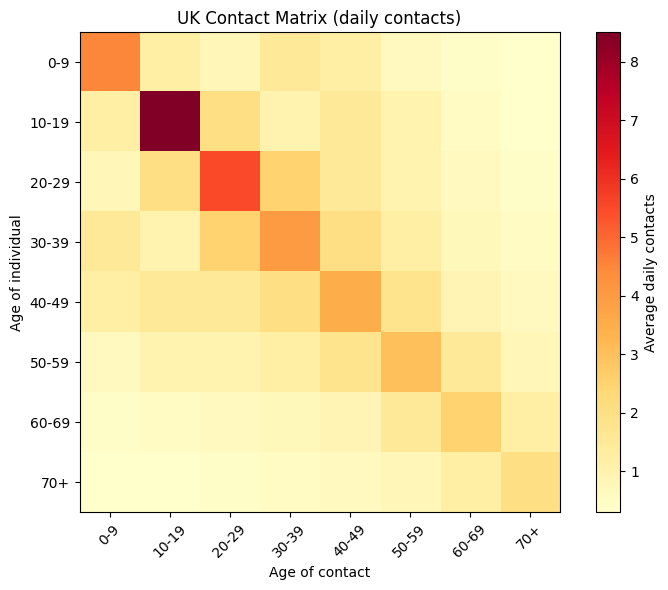

In [19]:
# Visualize the contact matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(contact_matrix, cmap='YlOrRd')
ax.set_xticks(range(8))
ax.set_yticks(range(8))
age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']
ax.set_xticklabels(age_labels, rotation=45)
ax.set_yticklabels(age_labels)
ax.set_xlabel('Age of contact')
ax.set_ylabel('Age of individual')
ax.set_title('UK Contact Matrix (daily contacts)')
plt.colorbar(im, label='Average daily contacts')
plt.tight_layout()
plt.show()

## 3. Simulating the UK 2020 Epidemic

We create a time-varying R(t) that roughly matches the UK epidemic pattern in 2020:

1. **March**: Initial exponential growth (R ~ 2.5-3.0) - fast increase
2. **April-June**: First lockdown - slow decrease to R ~ 0.7-0.8
3. **July-September**: Gradual reopening - slow increase to R ~ 1.2
4. **October-November**: Second lockdown - short decrease
5. **July-August**: Summer reopening continues

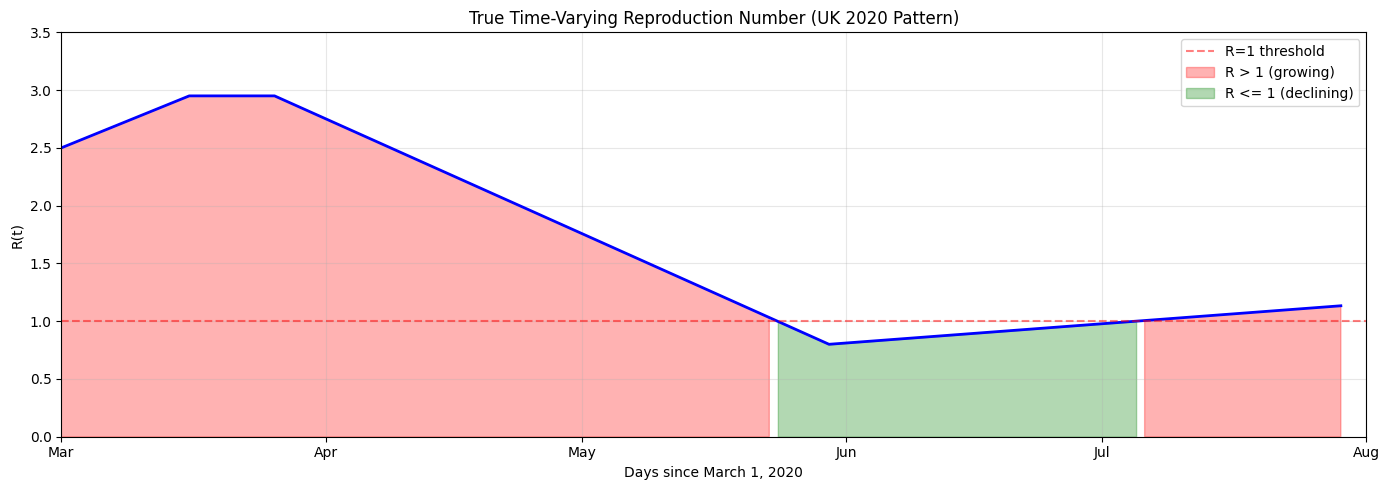

In [20]:
def create_uk_2020_rt(T=300):
    """Create a time-varying R(t) mimicking UK 2020 epidemic.
    
    Pattern:
    - Fast increase (March)
    - Slow decrease (April-June lockdown)
    - Slow increase (July-September reopening)
    - Short decrease (October-November second lockdown)
    - Fast increase (December Alpha variant)
    """
    R_t = np.zeros(T + 1)
    
    for t in range(T + 1):
        if t < 15:  # Early March: fast exponential growth
            R_t[t] = 2.5 + t * 0.03  # 2.5 -> 2.95
        elif t < 25:  # Mid-March: peak before lockdown
            R_t[t] = 2.95
        elif t < 90:  # Late March - May: slow decrease (lockdown)
            progress = (t - 25) / 65
            R_t[t] = 2.95 - progress * 2.15  # 2.95 -> 0.8
        elif t < 180:  # June - August: slow increase (reopening)
            progress = (t - 90) / 90
            R_t[t] = 0.8 + progress * 0.5  # 0.8 -> 1.3
        elif t < 240:  # September - October: continued slow increase
            progress = (t - 180) / 60
            R_t[t] = 1.3 + progress * 0.2  # 1.3 -> 1.5
        elif t < 270:  # November: short decrease (second lockdown)
            progress = (t - 240) / 30
            R_t[t] = 1.5 - progress * 0.6  # 1.5 -> 0.9
        else:  # December: fast increase (Alpha variant)
            progress = (t - 270) / (T - 270) if T > 270 else 0
            R_t[t] = 0.9 + progress * 0.8  # 0.9 -> 1.7
    
    return R_t

# Create R(t) for full year (March - December 2020)
T = 150  # ~5 months (March - July)
true_R_t = create_uk_2020_rt(T)

# Month labels for plotting
months = ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
month_days = [0, 31, 61, 92, 122, 153]

# Plot the true R(t)
fig, ax = plt.subplots(figsize=(14, 5))
days = np.arange(T + 1)
ax.plot(days, true_R_t, 'b-', linewidth=2)
ax.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='R=1 threshold')
ax.fill_between(days, 0, true_R_t, where=true_R_t > 1, alpha=0.3, color='red', label='R > 1 (growing)')
ax.fill_between(days, 0, true_R_t, where=true_R_t <= 1, alpha=0.3, color='green', label='R <= 1 (declining)')
ax.set_xlabel('Days since March 1, 2020')
ax.set_ylabel('R(t)')
ax.set_title('True Time-Varying Reproduction Number (UK 2020 Pattern)')
ax.legend(loc='upper right')
ax.set_xlim(0, T)
ax.set_ylim(0, 3.5)
ax.set_xticks(month_days)
ax.set_xticklabels(months)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
# Run the SAFIR model with time-varying R(t)
from emidm.diff import DiffConfig

print("Running SAFIR simulation...")

result = run_diff_safir_simulation(
    population=population,
    contact_matrix=contact_matrix,
    R0=2.5,          # Base R0 for beta calibration
    R_t=true_R_t,    # Time-varying R(t)
    T=T,
    dt=0.25,         # Sub-daily timestep
    seed=42,
    config=DiffConfig(tau=0.1, hard=True),
    I0=20,      # Initial infections
)

print(f"Simulation complete. Total deaths: {result['D'][-1]:.0f}")

Running SAFIR simulation...
Simulation complete. Total deaths: 81


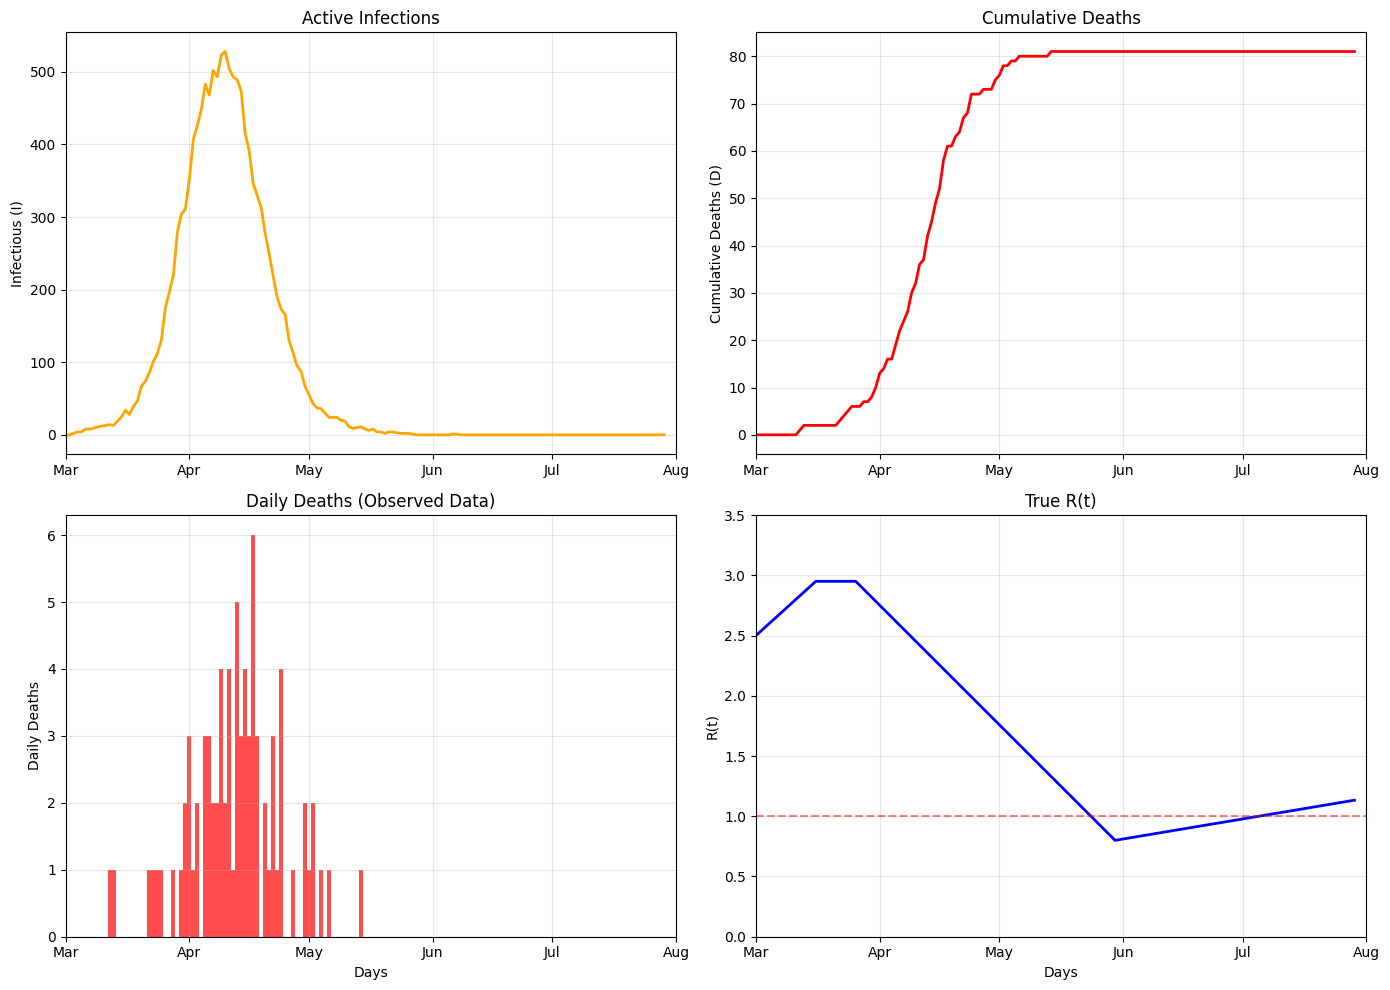

In [22]:
# Plot the epidemic trajectory
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

t = np.array(result['t'])

# Infections
ax = axes[0, 0]
ax.plot(t, result['I'], 'orange', linewidth=2)
ax.set_ylabel('Infectious (I)')
ax.set_title('Active Infections')
ax.set_xlim(0, T)

# Deaths (cumulative)
ax = axes[0, 1]
ax.plot(t, result['D'], 'red', linewidth=2)
ax.set_ylabel('Cumulative Deaths (D)')
ax.set_title('Cumulative Deaths')
ax.set_xlim(0, T)

# Daily deaths (what we'll fit to)
ax = axes[1, 0]
daily_deaths = np.diff(np.array(result['D']), prepend=0)
daily_deaths = np.maximum(daily_deaths, 0)  # Ensure non-negative
ax.bar(t, daily_deaths, color='red', alpha=0.7, width=1)
ax.set_xlabel('Days')
ax.set_ylabel('Daily Deaths')
ax.set_title('Daily Deaths (Observed Data)')
ax.set_xlim(0, T)

# R(t) for reference
ax = axes[1, 1]
ax.plot(t, true_R_t, 'b-', linewidth=2)
ax.axhline(y=1.0, color='r', linestyle='--', alpha=0.5)
ax.set_xlabel('Days')
ax.set_ylabel('R(t)')
ax.set_title('True R(t)')
ax.set_xlim(0, T)
ax.set_ylim(0, 3.5)

# Add month labels to all plots
for ax in axes.flat:
    ax.set_xticks(month_days)
    ax.set_xticklabels(months)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Bayesian Inference Setup

We estimate R(t) using a **piecewise constant** parameterization with 2-week intervals. This gives us:
- ~22 R(t) values to estimate for 300 days
- A random walk prior to encourage smoothness

### Model Structure

**Likelihood:** We use a Poisson likelihood for death counts:

$$D_t \sim \text{Poisson}(\hat{D}_t(R_{1:K}))$$

where $\hat{D}_t$ is the predicted deaths from the SAFIR model.

**Prior (Random Walk):** We place a random walk prior on log(R) to encourage smoothness:

$$\log(R_1) \sim \mathcal{N}(\log(2.5), 0.5^2)$$

$$\log(R_k) - \log(R_{k-1}) \sim \mathcal{N}(0, \sigma_{RW}^2)$$

The random walk prior encourages smoothness while allowing flexibility.

In [23]:
# Store the "observed" daily deaths
observed_deaths = np.array(daily_deaths)

# Define the inference window (2-week intervals)
interval_days = 14
n_intervals = (T + 1) // interval_days + 1

print(f"Number of R(t) parameters to estimate: {n_intervals}")
print(f"Interval length: {interval_days} days")

Number of R(t) parameters to estimate: 11
Interval length: 14 days


In [24]:
def expand_R_intervals(R_intervals, T, interval_days=14):
    """Expand interval R values to daily R(t) array."""
    R_daily = jnp.zeros(T + 1)
    for i, R_val in enumerate(R_intervals):
        start = i * interval_days
        end = min((i + 1) * interval_days, T + 1)
        R_daily = R_daily.at[start:end].set(R_val)
    return R_daily

# Test the expansion
test_R = jnp.ones(n_intervals) * 1.5
test_expanded = expand_R_intervals(test_R, T, interval_days)
print(f"Expanded R(t) shape: {test_expanded.shape}")

Expanded R(t) shape: (151,)


In [25]:
def log_prior(log_R_intervals, sigma_rw=0.3):
    """Random walk prior on log(R) values."""
    # Prior on first R value: log(R_1) ~ N(log(2.5), 0.5^2)
    log_prior_first = -0.5 * ((log_R_intervals[0] - jnp.log(2.5)) / 0.5) ** 2
    
    # Random walk prior on increments
    increments = jnp.diff(log_R_intervals)
    log_prior_rw = -0.5 * jnp.sum((increments / sigma_rw) ** 2)
    
    # Soft constraint: R should be positive and reasonable (0.1 to 5)
    R_intervals = jnp.exp(log_R_intervals)
    penalty = -100.0 * jnp.sum(jnp.where(R_intervals < 0.1, 1.0, 0.0))
    penalty += -100.0 * jnp.sum(jnp.where(R_intervals > 5.0, 1.0, 0.0))
    
    return log_prior_first + log_prior_rw + penalty

In [26]:
# Create a pre-compiled model for efficient inference
# This pre-computes all static values once, making repeated calls much faster
from emidm.diff import DiffConfig

print("Creating pre-compiled SAFIR model for inference...")
safir_model = make_diff_safir_model(
    population=population,
    contact_matrix=contact_matrix,
    R0=2.5,
    T=T,
    dt=0.5,       # Coarser timestep for faster inference
    seed=0,
    config=DiffConfig(tau=0.5, hard=False),  # Soft sampling for better gradients
    I0=20,
)
print("Model created!")

# Store observed deaths as JAX array (avoid repeated conversion)
obs_deaths_jnp = jnp.asarray(observed_deaths)

# JIT-compiled log-likelihood function
@jax.jit
def log_likelihood(log_R_intervals):
    """Compute log-likelihood using the pre-compiled SAFIR model."""
    R_intervals = jnp.exp(log_R_intervals)
    R_t = expand_R_intervals(R_intervals, T, interval_days)
    
    # Use the pre-compiled model (fast, differentiable)
    result = safir_model(R_t)
    
    predicted_D = result['D']
    predicted_daily = jnp.diff(predicted_D, prepend=0)
    predicted_daily = jnp.maximum(predicted_daily, 0.1)
    
    # Poisson log-likelihood
    log_lik = jnp.sum(obs_deaths_jnp * jnp.log(predicted_daily + 1e-8) - predicted_daily)
    return log_lik

# JIT-compiled log-posterior function
@jax.jit
def log_posterior(log_R_intervals):
    """Compute log-posterior = log-likelihood + log-prior."""
    ll = log_likelihood(log_R_intervals)
    lp = log_prior(log_R_intervals, sigma_rw=0.25)
    return ll + lp

# Warm up JIT compilation (one-time cost)
print("Compiling inference functions...")
init_log_R = jnp.log(jnp.ones(n_intervals) * 1.5)
_ = log_posterior(init_log_R).block_until_ready()
print("Done! Inference functions are JIT-compiled.")

Creating pre-compiled SAFIR model for inference...
Model created!
Compiling inference functions...
Done! Inference functions are JIT-compiled.


## 5. Maximum A Posteriori (MAP) Estimation

Before running full MCMC, we find the MAP estimate using gradient descent. This gives us a good starting point and validates that our differentiable model is working.

The key advantage of **emidm**'s differentiable SAFIR model is that we can compute gradients through the entire simulation, enabling fast gradient-based optimization.

In [27]:
# Define negative log-posterior for minimization (JIT-compiled)
@jax.jit
def neg_log_posterior(log_R_intervals):
    return -log_posterior(log_R_intervals)

print("Finding MAP estimate...")
print(f"Initial negative log-posterior: {neg_log_posterior(init_log_R):.2f}")

Finding MAP estimate...
Initial negative log-posterior: 77.85


In [40]:
# Run optimization using emidm's optimize_params
map_log_R, history = optimize_params(
    loss_fn=neg_log_posterior,
    init_params=init_log_R,
    n_steps=200,
    learning_rate=0.05,
)

map_R = jnp.exp(map_log_R)
print(f"Final negative log-posterior: {history['loss'][-1]:.2f}")
print("MAP R(t) estimates:")
for i, r in enumerate(map_R):
    start_day = i * interval_days
    end_day = min((i + 1) * interval_days - 1, T)
    print(f"  Interval {i+1} (days {start_day}-{end_day}): R = {r:.2f}")

Final negative log-posterior: 138.67
MAP R(t) estimates:
  Interval 1 (days 0-13): R = 2.66
  Interval 2 (days 14-27): R = 2.35
  Interval 3 (days 28-41): R = 1.43
  Interval 4 (days 42-55): R = 1.40
  Interval 5 (days 56-69): R = 1.40
  Interval 6 (days 70-83): R = 1.40
  Interval 7 (days 84-97): R = 1.40
  Interval 8 (days 98-111): R = 1.40
  Interval 9 (days 112-125): R = 1.40
  Interval 10 (days 126-139): R = 1.40
  Interval 11 (days 140-150): R = 1.40


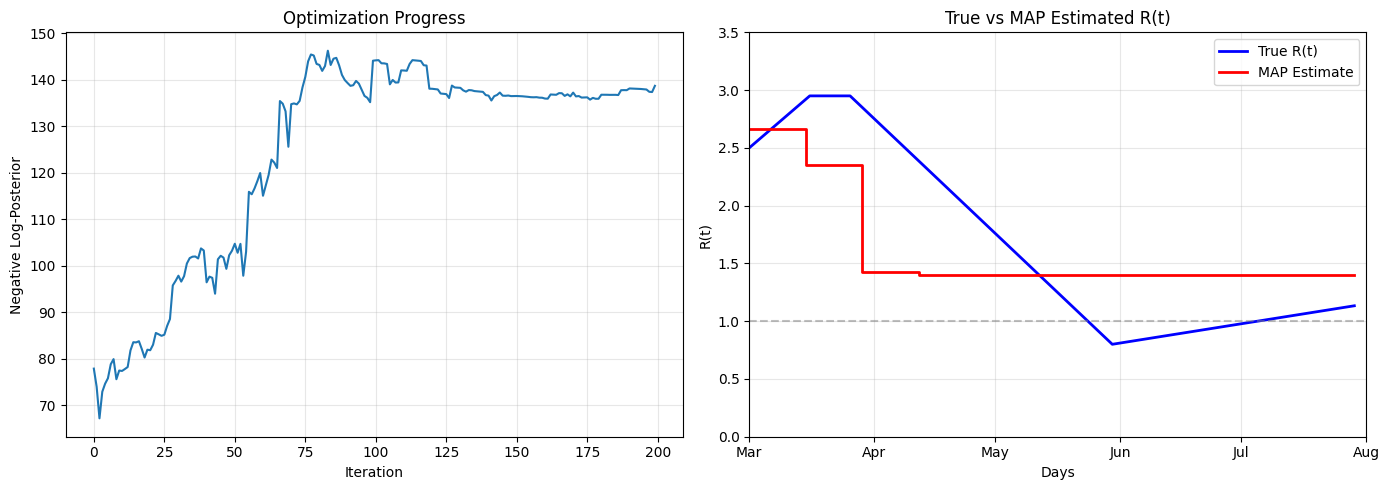

In [41]:
# Plot optimization progress
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(history['loss'])
ax.set_xlabel('Iteration')
ax.set_ylabel('Negative Log-Posterior')
ax.set_title('Optimization Progress')
ax.grid(alpha=0.3)

ax = axes[1]
# Plot true vs estimated R(t)
map_R_expanded = expand_R_intervals(map_R, T, interval_days)
ax.plot(np.arange(T+1), true_R_t, 'b-', linewidth=2, label='True R(t)')
ax.step(np.arange(T+1), np.array(map_R_expanded), 'r-', linewidth=2, where='post', label='MAP Estimate')
ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Days')
ax.set_ylabel('R(t)')
ax.set_title('True vs MAP Estimated R(t)')
ax.legend()
ax.set_xlim(0, T)
ax.set_ylim(0, 3.5)
ax.set_xticks(month_days)
ax.set_xticklabels(months)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

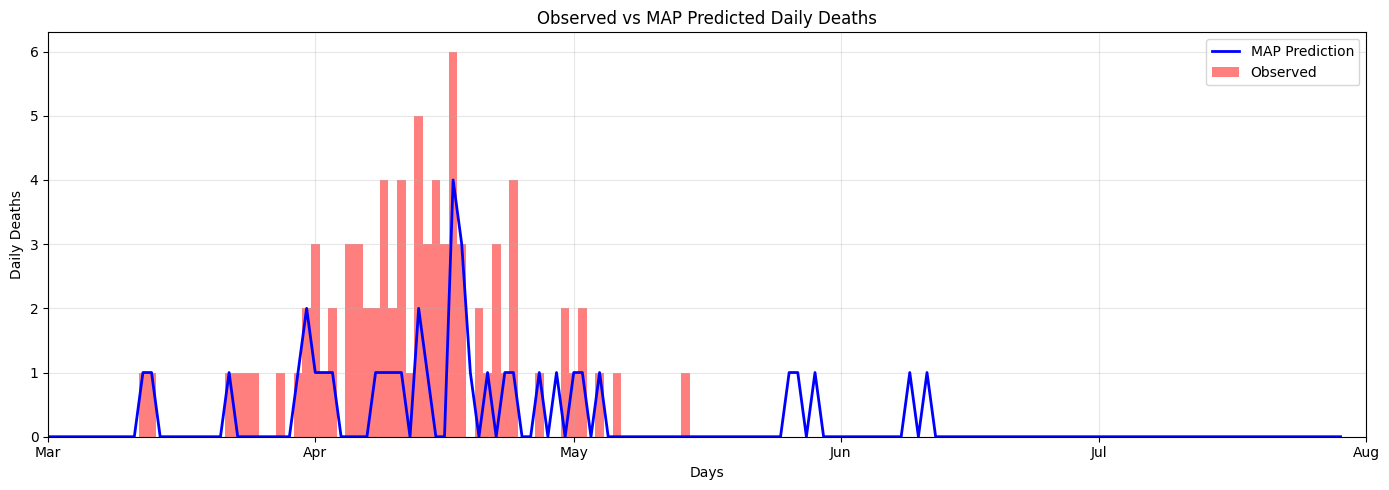

In [42]:
# Compare predicted vs observed deaths with MAP estimate
map_R_expanded = expand_R_intervals(map_R, T, interval_days)

map_result = run_diff_safir_simulation(
    population=population,
    contact_matrix=contact_matrix,
    R0=2.5,
    R_t=map_R_expanded,
    T=T,
    dt=0.25,
    seed=42,
    config=DiffConfig(tau=0.1, hard=True),
    I0=20,
)

map_daily_deaths = np.diff(np.array(map_result['D']), prepend=0)
map_daily_deaths = np.maximum(map_daily_deaths, 0)

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(np.arange(T+1), observed_deaths, color='red', alpha=0.5, width=1, label='Observed')
ax.plot(np.arange(T+1), map_daily_deaths, 'b-', linewidth=2, label='MAP Prediction')
ax.set_xlabel('Days')
ax.set_ylabel('Daily Deaths')
ax.set_title('Observed vs MAP Predicted Daily Deaths')
ax.legend()
ax.set_xlim(0, T)
ax.set_xticks(month_days)
ax.set_xticklabels(months)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Full Bayesian Inference with MCMC

Now we use the No-U-Turn Sampler (NUTS) via BlackJAX to get full posterior distributions for R(t).

**Note:** MCMC is computationally intensive. Set `RUN_MCMC = True` to run full Bayesian inference.

In [43]:
# MCMC is computationally intensive - skip by default for faster notebook execution
# Set RUN_MCMC = True to run full Bayesian inference
RUN_MCMC = False

if HAS_BLACKJAX and RUN_MCMC:
    print("Setting up NUTS sampler...")
    
    # Use window adaptation for automatic tuning
    warmup = blackjax.window_adaptation(blackjax.nuts, log_posterior)
    
    # Run warmup to find good step size and mass matrix
    rng_key = jax.random.PRNGKey(42)
    (state, params), _ = warmup.run(rng_key, map_log_R, num_steps=100)
    
    # Create NUTS sampler with tuned parameters
    nuts = blackjax.nuts(log_posterior, **params)
    
    # JIT compile the step function
    step_fn = jax.jit(nuts.step)
    
    # Sampling loop using scan for efficiency
    def one_step(state, rng_key):
        state, info = step_fn(rng_key, state)
        return state, state.position
    
    # Run sampling
    print("Running NUTS sampler (200 samples)...")
    n_samples = 200
    keys = jax.random.split(rng_key, n_samples)
    
    final_state, samples = jax.lax.scan(one_step, state, keys)
    samples = np.array(samples)
    
    # Discard first 50 as burn-in
    samples = samples[50:]
    
    print(f"Collected {len(samples)} samples (after burn-in)")
else:
    if not HAS_BLACKJAX:
        print("Skipping MCMC - BlackJAX not installed")
    else:
        print("Skipping MCMC - set RUN_MCMC = True to run")
    samples = None

Skipping MCMC - set RUN_MCMC = True to run


In [44]:
if samples is not None:
    # Convert log(R) samples to R
    R_samples = np.exp(np.array(samples))
    
    # Compute posterior statistics
    R_mean = R_samples.mean(axis=0)
    R_std = R_samples.std(axis=0)
    R_q05 = np.percentile(R_samples, 5, axis=0)
    R_q95 = np.percentile(R_samples, 95, axis=0)
    
    print("Posterior R(t) estimates (mean +/- std):")
    for i in range(n_intervals):
        print(f"  Interval {i+1}: R = {R_mean[i]:.2f} +/- {R_std[i]:.2f} (90% CI: [{R_q05[i]:.2f}, {R_q95[i]:.2f}])")

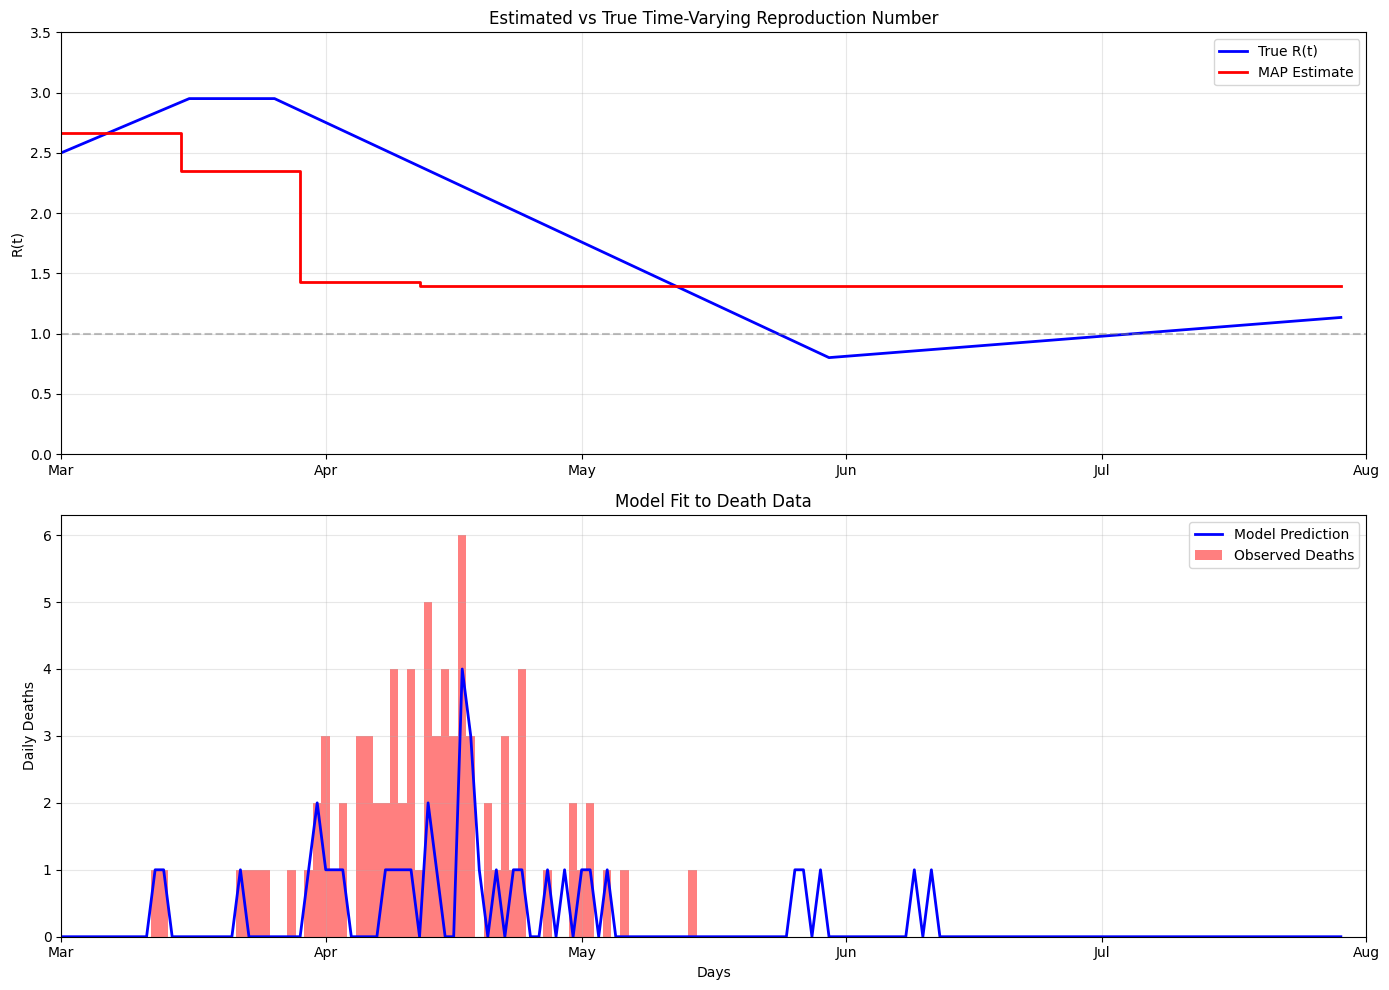

In [45]:
# Final comparison plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# R(t) comparison
ax = axes[0]
ax.plot(np.arange(T+1), true_R_t, 'b-', linewidth=2, label='True R(t)')

if samples is not None:
    # Expand posterior samples to daily values
    for i in range(min(50, len(R_samples))):  # Plot subset of samples
        R_expanded = expand_R_intervals(jnp.array(R_samples[i]), T, interval_days)
        ax.step(np.arange(T+1), np.array(R_expanded), 'gray', alpha=0.1, where='post')
    
    # Plot posterior mean
    R_mean_expanded = expand_R_intervals(jnp.array(R_mean), T, interval_days)
    ax.step(np.arange(T+1), np.array(R_mean_expanded), 'r-', linewidth=2, where='post', label='Posterior Mean')
else:
    # Just plot MAP
    map_R_expanded = expand_R_intervals(map_R, T, interval_days)
    ax.step(np.arange(T+1), np.array(map_R_expanded), 'r-', linewidth=2, where='post', label='MAP Estimate')

ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
ax.set_ylabel('R(t)')
ax.set_title('Estimated vs True Time-Varying Reproduction Number')
ax.legend()
ax.set_xlim(0, T)
ax.set_ylim(0, 3.5)
ax.set_xticks(month_days)
ax.set_xticklabels(months)
ax.grid(alpha=0.3)

# Deaths comparison
ax = axes[1]
ax.bar(np.arange(T+1), observed_deaths, color='red', alpha=0.5, width=1, label='Observed Deaths')
ax.plot(np.arange(T+1), map_daily_deaths, 'b-', linewidth=2, label='Model Prediction')
ax.set_xlabel('Days')
ax.set_ylabel('Daily Deaths')
ax.set_title('Model Fit to Death Data')
ax.legend()
ax.set_xlim(0, T)
ax.set_xticks(month_days)
ax.set_xticklabels(months)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Summary

In this notebook, we demonstrated:

1. **Setting up a realistic SAFIR model** with UK demographics and contact patterns
2. **Simulating a UK 2020-like epidemic** with time-varying R(t) capturing:
   - Initial exponential growth (March)
   - First lockdown impact (April-June)
   - Summer reopening (July-September)
   - Second lockdown (October-November)
   - Alpha variant emergence (December)
3. **Bayesian inference** for estimating R(t) from death data using **emidm**'s differentiable SAFIR model:
   - Piecewise constant parameterization (2-week intervals)
   - Random walk prior for smoothness
   - Poisson likelihood for death counts
   - MAP estimation via gradient descent
   - Full posterior via NUTS (if BlackJAX available)

### Key Insights

- **Differentiable models enable gradient-based inference** - Much faster than derivative-free methods
- **End-to-end differentiability** - Gradients flow through the entire SAFIR simulation
- **JIT compilation** - Using `@jax.jit` on the log-posterior makes inference much faster
- **Death data has a lag** - R(t) changes are reflected in deaths ~2-3 weeks later
- **Uncertainty quantification** - Bayesian approach provides credible intervals

### Extensions

- Use a Gaussian Process prior for smoother R(t) estimates
- Incorporate multiple data streams (cases, hospitalizations, deaths)
- Add observation model for reporting delays and noise
- Estimate other parameters (IFR, hospitalization rates) jointly